<a href="https://colab.research.google.com/github/Xiangmingchen/Go-AI/blob/master/go_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install tensorflow==2.0.0-beta1

# Load the TensorBoard notebook extension
# Restart the jupyter notebook if you just installed TF 2.0 Beta
%load_ext tensorboard

     |████████████████████████████████| 87.9MB 1.3MB/s 
     |████████████████████████████████| 501kB 42.5MB/s 
     |████████████████████████████████| 3.1MB 37.4MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import gym

In [0]:
!rm -rf ./logs/

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [0]:
go_env = gym.make('gym_go:go-v0', size='S', reward_method='heuristic')

In [0]:
board_size = 7

# Machine Learning Models
Actor-Critic method

In [0]:
from tensorflow.keras import layers

In [0]:
actor = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Flatten(),
    layers.Softmax(),
    layers.Reshape((board_size, board_size))
])

In [0]:
critic = tf.keras.Sequential([
    layers.Conv2D(input_shape=(board_size, board_size, 4), bias_initializer="ones", 
                  filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=64, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=16, kernel_size=5, padding="same"),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(filters=1, kernel_size=5, padding="same"),
    layers.Reshape((board_size, board_size))
])

In [0]:
state = go_env.reset()
state, reward, done, info = go_env.step((3,5))
state, reward, done, info = go_env.step((5,3))

In [0]:
def plot_state(state, channels_last=False):
    plt.figure()
    for i, (layer, name) in enumerate(zip([state[0], state[1], state[2], state[3]] if not channels_last else 
                                          [state[:,:,0], state[:,:,1], state[:,:,2], state[:,:,3]], 
                                          ['black', 'white', 'ko', 'pass'])):
        plt.subplot(2,2,i+1)
        plt.title(name)
        plt.imshow(layer)
    plt.tight_layout()

Tensorflow expects images to be `channels last`. 

This can be adapted to with `tranpose`.


Ensure the `transpose` function doesn't change anything visually

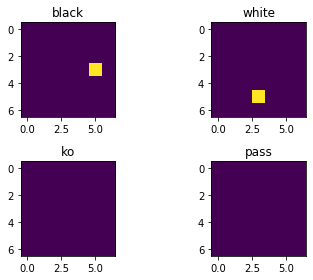

In [0]:
plot_state(state, channels_last=False)

In [0]:
state = state.transpose(1,2,0).reshape(1,7,7,4)

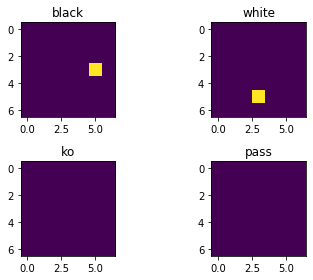

In [0]:
plot_state(state[0], channels_last=True)

### Initialization of models should be random

In [0]:
probs = actor.predict(state)

In [0]:
values = critic.predict(state)

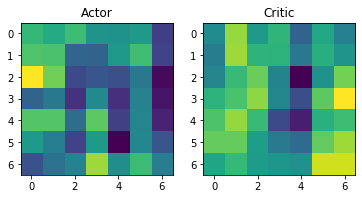

In [0]:
plt.subplot(1,2,1)
plt.title('Actor')
plt.imshow(probs[0])
plt.subplot(1,2,2)
plt.title('Critic')
plt.imshow(values[0])

# Training Setup

### Hyperparameters

In [0]:
NUM_EPISODES = 1000
BATCH_SIZE = 64
REPLAY_MEM_SIZE = 1e6
OPPONENT_UPDATE = 10

In [0]:
from collections import deque

In [0]:
memory = deque(maxlen=int(REPLAY_MEM_SIZE))

### Functions

In [0]:
def play():
    pass

In [0]:
def update_critic():
    pass

In [0]:
def update_actor():
    pass

In [0]:
def train(episode):
    if episode % OPPONENT_UPDATE == 0:
        # TODO sync opponent
        pass
    
    play()
    update_critic()
    
    update_actor()

# Train

In [0]:
for episode in range(NUM_EPISODES):
    train(episode)

# Evaluate
Play against the actor 💪

In [0]:
env = gym.make('gym_go:go-v0', size='S')

state = env.reset()

while True:
    env.render()
    
    # Actor's move
    state = state.transpose(1,2,0).reshape(1,7,7,4)
    act_prob_distr = actor.predict(state)
    action_1d = np.random.choice(np.arange(49), p=act_prob_distr.flatten())
    action = (action_1d // 7, action_1d % 7)
    
    state, action, reward, info = env.step(action)
    
    env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space\n")
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, action, reward, info = env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   | B |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  ---------

KeyboardInterrupt: 